In [1]:
import os
os.chdir("/root/dev/vcmr")
import random

import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

from train import MLP, MusicTransformer, Identical, SampleCNNMLP


In [2]:
music_features_dir = './music_features_test'
music_samplecnn_dir = './music_SampleCNN_test'
image_features_dir = './image_features_test'
image_dir = './images_test'
music_dir = './music_test'

def compute_recall_at_k(similarities, ground_truth, k):
    topk = similarities.topk(k, dim=1, largest=True, sorted=True).indices  # (num_queries, k)
    recall = (topk == ground_truth.unsqueeze(1)).any(dim=1).float().mean().item()
    return recall

def compute_mrr(similarities, ground_truth):
    ranks = (similarities.argsort(descending=True) == ground_truth.unsqueeze(1)).float()
    ranks = ranks.nonzero(as_tuple=False)
    ranks = ranks[ranks[:,1] == ground_truth[ranks[:,0]], 1] + 1  # 순위는 1부터 시작
    reciprocal_ranks = 1.0 / ranks.float()
    mrr = reciprocal_ranks.mean().item()
    return mrr

def compute_map(similarities, ground_truth):
    sorted_indices = similarities.argsort(descending=True)  # (num_queries, num_targets)
    num_queries = similarities.size(0)
    average_precisions = []

    for i in range(num_queries):
        rank = (sorted_indices[i] == ground_truth[i]).nonzero(as_tuple=False)
        if rank.numel() == 0:
            average_precisions.append(0.0)
        else:
            rank = rank.item() + 1  # 순위는 1부터 시작
            average_precisions.append(1.0 / rank)

    map_score = np.mean(average_precisions)
    return map_score

def compute_median_rank(similarities, ground_truth):
    sorted_indices = similarities.argsort(descending=True)  # (num_queries, num_targets)
    num_queries = similarities.size(0)
    ranks = []

    for i in range(num_queries):
        rank = (sorted_indices[i] == ground_truth[i]).nonzero(as_tuple=False)
        if rank.numel() == 0:
            ranks.append(similarities.size(1) + 1)  # 정답이 없을 경우 최대 순위 +1
        else:
            ranks.append(rank.item() + 1)  # 순위는 1부터 시작

    median_rank = np.median(ranks)
    return median_rank

class MusicImageDataset(Dataset):
    def __init__(self, music_features_dir, image_features_dir, image_dir, is_transformer):
        self.music_features_dir = music_features_dir
        self.image_features_dir = image_features_dir
        self.music_samplecnn_dir = music_samplecnn_dir
        self.is_transformer = is_transformer
        self.image_dir = image_dir

        files = [os.path.splitext(f)[0] for f in os.listdir(music_features_dir) if f.endswith('.npy')]

        if self.is_transformer:
            sample_cnn_files = [os.path.splitext(f)[0]  for f in os.listdir(music_samplecnn_dir) if f.endswith('.npy')]
            file_set = set(files).intersection(sample_cnn_files)
            self.filenames = sorted(list(file_set))
        else:
            self.filenames = sorted(files)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        music_embed = np.load(os.path.join(self.music_features_dir, f"{fname}.npy")).astype(np.float32)
        image_embed = np.load(os.path.join(self.image_features_dir, f"{fname}.npy")).astype(np.float32)
        music_samplecnn_embed = music_embed
        if self.is_transformer:
            music_samplecnn_embed = np.load(os.path.join(self.music_samplecnn_dir, f"{fname}.npy")).astype(np.float32)
        return image_embed, music_embed, music_samplecnn_embed, idx, fname

In [3]:
def get_raw_embeddings(image_proj, music_proj, dataloader, device, is_transformer = False):
    all_music_embeddings = []
    all_fnames = []
    image_embeddings = []
    ground_truth = []

    with torch.no_grad():
        for image_embed, music_embed, music_samplecnn_embed, idx, fname in tqdm(dataloader, desc="음악 임베딩 계산"):
            all_music_embeddings.append(torch.Tensor(music_embed).cpu())
            image_embeddings.append(torch.Tensor(image_embed).cpu())
            all_fnames.extend(fname)
    all_music_embeddings = torch.cat(all_music_embeddings, dim=0)  # (num_music, 128)
    all_music_embeddings = F.normalize(all_music_embeddings, dim=1)  # 정규화
    image_embeddings = torch.cat(image_embeddings, dim=0)  # (num_images, 128)
    image_embeddings = F.normalize(image_embeddings, dim=1)  # 정규화
    return image_embeddings, all_music_embeddings, all_fnames

def get_embeddings(image_proj, music_proj, dataloader, device, is_transformer_type = False):
    all_music_embeddings = []
    all_fnames = []

    print("음악 임베딩 사전 계산 중...")
    with torch.no_grad():
        for image_embed, music_embed, music_samplecnn_embed, idx, fname in tqdm(dataloader, desc="음악 임베딩 계산"):
            music_embed = torch.Tensor(music_embed).to(device)  # (batch_size, 50)
            music_samplecnn_embed = torch.Tensor(music_samplecnn_embed).to(device)  # (batch_size, 50)
            if is_transformer_type:
                projected_music = music_proj(music_embed, music_samplecnn_embed)  # (batch_size, 128)
            else:
                projected_music = music_proj(music_embed)
            all_music_embeddings.append(projected_music.cpu())
            all_fnames.extend(fname)
    all_music_embeddings = torch.cat(all_music_embeddings, dim=0)  # (num_music, 128)
    all_music_embeddings = F.normalize(all_music_embeddings, dim=1)  # 정규화

    print("이미지 임베딩 사전 계산 중...")
    image_embeddings = []
    ground_truth = []
    with torch.no_grad():
        for image_embed, music_embed, music_samplecnn_embed, idx, fname in tqdm(dataloader, desc="이미지 임베딩 계산"):
            image_embed = torch.Tensor(image_embed).to(device)  # (batch_size, 512)
            projected_image = image_proj(image_embed)  # (batch_size, 128)
            image_embeddings.append(projected_image.cpu())
            ground_truth.extend([i for i in range(len(fname))])
    image_embeddings = torch.cat(image_embeddings, dim=0)  # (num_images, 128)
    image_embeddings = F.normalize(image_embeddings, dim=1)  # 정규화

    return image_embeddings, all_music_embeddings, all_fnames

def evaluate_model(image_embeddings, music_embeddings, device, topk=[1,5,10]):
    print("유사도 매트릭스 계산 중...")
    similarities = torch.mm(image_embeddings, music_embeddings.T)  # (num_images, num_music)
    num_queries = similarities.size(0)
    num_targets = similarities.size(1)
    ground_truth_indices = torch.arange(num_queries).to(device)  # (num_queries,)
    similarities = similarities.to(device)

    print("평가 지표 계산 중...")
    metrics = {}
    for k in topk:
        metrics[f'Recall@{k}'] = compute_recall_at_k(similarities, ground_truth_indices, k)

    # metrics["MRR"] = compute_mrr(similarities, ground_truth_indices)
    metrics["MR"] = compute_median_rank(similarities, ground_truth_indices)
    metrics["mAP"] = compute_map(similarities, ground_truth_indices)

    print("평가 완료!")
    return metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
def get_model(checkpoint_path):
    def is_transformer(checkpoint_path):
        return "trans" in checkpoint_path
    def is_samplecnn(checkpoint_path):
        return "samplecnn" in checkpoint_path
    pth_dir = checkpoint_path

    __is_transformer = False
    __is_samplecnn = False

    checkpoint = torch.load(pth_dir)
    image_proj_state_dict = checkpoint['image_proj_state_dict']
    music_proj_state_dict = checkpoint['music_proj_state_dict']

    if is_transformer(checkpoint_path):
        image_proj = MLP(input_dim=512, output_dim=256)
        music_proj = MusicTransformer(input_dim=512, output_dim=256)
        __is_transformer = True
    elif is_samplecnn(checkpoint_path):
        image_proj = Identical()
        music_proj = SampleCNNMLP(input_dim=512, output_dim=256)
        __is_samplecnn = True
    else:
        image_proj = MLP(input_dim=512, output_dim=256)
        music_proj = MLP(input_dim=512, output_dim=256)
    image_proj.load_state_dict(image_proj_state_dict)
    image_proj.cuda().eval()
    music_proj.load_state_dict(music_proj_state_dict)
    music_proj.cuda().eval()

    return image_proj, music_proj, __is_transformer or __is_samplecnn

In [5]:
def print_metrics(metrics):
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

# image_embeddings, all_music_embeddings, all_fnames = get_raw_embeddings(image_proj, music_proj, dataloader, device, is_transformer)
# metrics = evaluate_model(image_embeddings, all_music_embeddings, device, topk=[10, 9093 // 20, 9093 // 10, 9093 * 2 // 10, 9093 * 3 // 10])
# print_metrics(metrics)
# print()

for model_dir in [
    # "./checkpoint_epoch_200_cossim_1.pth",
    # "./checkpoint_epoch_200_cossim_3.pth",
    # "./checkpoint_epoch_200_infonce.pth",
    # "./checkpoint_epoch_200_transformer_infonce.pth",
    #"./checkpoint_epoch_200_samplecnn_l.pth",
    "./checkpoint_epoch_100_transformer_t0.2.pth"

]:
    image_proj, music_proj, is_transformer_type = get_model(model_dir)
    dataset = MusicImageDataset(music_features_dir, image_features_dir,
                                image_dir, is_transformer_type)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    image_embeddings, all_music_embeddings, all_fnames = get_embeddings(
        image_proj, music_proj, dataloader, device, is_transformer_type)
    l = len(image_embeddings)
    metrics = evaluate_model(image_embeddings, all_music_embeddings, device,
                             topk=[10, l // 20, l // 10, l * 2 // 10, l * 3 // 10])
    print_metrics(metrics)

/tmp/ipykernel_1854228/725168493.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pth_dir)
/root/anaconda3/envs/clipenv/lib/python3.10/site-packa

음악 임베딩 사전 계산 중...


음악 임베딩 계산: 100%|██████████| 142/142 [00:00<00:00, 157.57it/s]


이미지 임베딩 사전 계산 중...


이미지 임베딩 계산: 100%|██████████| 142/142 [00:00<00:00, 202.33it/s]


유사도 매트릭스 계산 중...
평가 지표 계산 중...
평가 완료!
Recall@10: 0.0177
Recall@453: 0.3092
Recall@906: 0.4532
Recall@1813: 0.6302
Recall@2719: 0.7424
MR: 1105.0000
mAP: 0.0097


In [ ]:
import json

info = {}
for i, f in enumerate(all_fnames):
    info[f] = all_music_embeddings[i].numpy().tolist()

with open('./processed_music_embeddings.json', 'w') as f:
    json.dump(info, f, indent=4)

In [8]:
import music_embeddings_pb2

embeddings_list = all_music_embeddings.numpy().tolist()
exportable = [all_fnames, embeddings_list]

music_embeddings = music_embeddings_pb2.MusicEmbeddings()

for fname, embedding in zip(exportable[0], exportable[1]):
    me = music_embeddings.embeddings.add()
    me.filename = fname
    me.embedding.extend(embedding)

# 바이너리 파일로 저장
with open('music_embeddings.bin', 'wb') as f:
    f.write(music_embeddings.SerializeToString())

print("Protobuf 파일 생성 완료: music_embeddings.bin")

Protobuf 파일 생성 완료: music_embeddings.bin


In [9]:
F.cosine_similarity(all_music_embeddings[0].unsqueeze(0), image_embeddings[0].unsqueeze(0))

tensor([0.0904])

2259


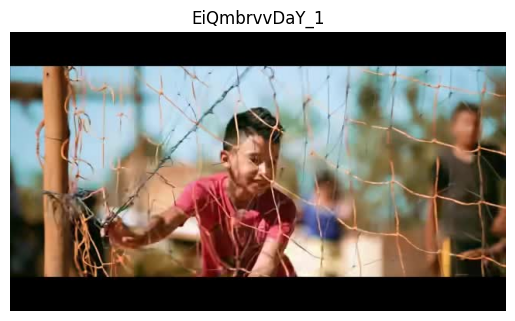

정답 음악: EiQmbrvvDaY_1
1495. EiQmbrvvDaY_1: 0.2654 [GT]
TopK
1. GsgIUYuXZj4_1: 0.7194
2. OSaTooPMug4_3: 0.7183
3. bgf18kANm_k_1: 0.7061
4. N4pqF-hwFM4_3: 0.7027
5. dEjA3uw5s3I_1: 0.7013
6. ovX1HloCgdA_1: 0.6987
7. HwEtcLfST54_1: 0.6982
8. bgf18kANm_k_2: 0.6982
9. 0jnZreO4Dvs_1: 0.6964
10. weeI1G46q0o_2: 0.6962
Quantile
0.719	0.506	0.370	0.286	0.222	0.173	0.135	0.100	0.072	0.044	0.024	0.004	-0.012	-0.026	-0.039	-0.052	-0.067	-0.086	-0.112	-0.149	-0.269


In [19]:
from IPython.display import Audio, display
def visualize_recommendations(fnames, image_proj, dataloader, device, idx, music_embeddings, image_dir, topk=10, quantile=20):

    with torch.no_grad():
        image_embed, _, _, _, fname = dataloader.dataset[idx]
        image_embed = torch.Tensor(image_embed).unsqueeze(0).to(device)  # (1, 512)
        projected_image = image_proj(image_embed) # (1, 128)
        projected_image = F.normalize(projected_image, dim=1)  # 정규화

        length = len(music_embeddings) #9093
        similarities = torch.mm(projected_image, music_embeddings.to(device).T)  # (1, num_music)
        topk_similarities, topk_indices = similarities.topk(length, dim=1, largest=True, sorted=True)

        topk_similarities = topk_similarities.squeeze(0).cpu().numpy()
        topk_indices = topk_indices.squeeze(0).cpu().numpy()

        gt_fname = os.path.splitext(fname)[0]
        gt_idx = fnames.index(gt_fname)

        image_path = os.path.join(image_dir, f"{gt_fname}.jpg")
        image = Image.open(image_path)
        plt.imshow(image)
        plt.axis('off')  # 축 숨기기
        plt.title(f"{gt_fname}")
        plt.show()
        print(f"정답 음악: {gt_fname}")

        for rank, (sim, idx) in enumerate(zip(topk_similarities, topk_indices), start=1):
            music_fname = fnames[idx]
            if idx == gt_idx:
                print(f"{rank}. {music_fname}: {sim:.4f} [GT]")
        # display(Audio(os.path.join(music_dir, f"{gt_fname}.mp3")))

        print("TopK")

        for rank, (sim, idx) in enumerate(zip(topk_similarities, topk_indices), start=1):
            if rank > topk:
                break
            music_fname = fnames[idx]
            print(f"{rank}. {music_fname}: {sim:.4f}")
            # audio = Audio(os.path.join(music_dir, music_fname + ".mp3"))
            # display(audio)

        print("Quantile")
        quantiles = []
        for j in range(0, length, max(1, length // quantile)):
            quantiles.append(topk_similarities[j])
        print("\t".join([f"{q:.3f}" for q in quantiles]))
idx = random.randint(0, len(dataset))
print(idx)
visualize_recommendations(all_fnames, image_proj, dataloader, device, idx, all_music_embeddings, image_dir, topk=10)

In [ ]:
# COSINE SIMILARITY (Positive:Negative=1:1)
{'Recall@1': 0.00021994940470904112,
 'Recall@5': 0.000989772379398346,
 'Recall@10': 0.0016496204771101475,
 'MR': np.float64(3914.0),
 'mAP': np.float64(0.001565276893921723)}

# COSINE SIMILARITY (Positive:Negative=1:3)
{'Recall@1': 0.0003299241070635617,
 'Recall@5': 0.0015396458329632878,
 'Recall@10': 0.0024194433353841305,
 'MR': np.float64(4223.0),
 'mAP': np.float64(0.0019648388151269503)}

# InfoNCE
{'Recall@1': 0.00043989880941808224,
 'Recall@5': 0.001759595237672329,
 'Recall@10': 0.003519190475344658,
 'MR': np.float64(2966.0),
 'mAP': np.float64(0.0025402929552953454)}

# 아래부터는 안 돠도 됨

In [ ]:
# indexing the testset (6.0s for 10086 files)

music_features_dir = './music_features_test'
image_features_dir = './image_features_test'
image_dir = './images_test'

files = sorted([f for f in os.listdir(music_features_dir) if f.endswith('.npy')])
filenames = [os.path.splitext(f)[0] for f in files]
music_embeddings = {}
for f in files:
    stem = os.path.splitext(f)[0]
    # music_embeddings[stem] = np.load(os.path.join(music_features_dir, f)).astype(np.float32)
    music_embed = torch.Tensor(music_embed).unsqueeze(0).cuda()
    with torch.no_grad():
        music_embed_output = model(music_embed)
    music_embeddings[stem] = music_embed_output.detach().cpu().numpy()

In [ ]:
# 여기부터 안봐도됨

In [ ]:


base_fname = files[idx]
image_embed = np.load(os.path.join(image_features_dir, base_fname)).astype(np.float32)
image_embed = torch.Tensor(image_embed).unsqueeze(0).cuda()
with torch.no_grad():
    image_embed_output = model(image_embed)

similarities = []
for fname, music_embed in music_embeddings.items():
    sim = F.cosine_similarity(image_embed_output, torch.Tensor(music_embed).cuda()).item()
    similarities.append((fname, sim))
    if fname == base_fname.split('.')[0]:
        print(f"{fname}: {sim:.4f} - GT")
top_10_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:20]
for fname, sim in top_10_similarities:
    print(f"{fname}: {sim:.4f}")

image_path = f"./{image_dir}/{base_fname[:-4]}.jpg"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
music_embed = music_embeddings["LgJhcGl_h7Y_2"]

image_embed_outputs = []
for idx in range(0, 9093):
    image_embed = np.load(os.path.join(image_features_dir, files[idx])).astype(np.float32)
    image_embed = torch.Tensor(image_embed).unsqueeze(0).cuda()
    with torch.no_grad():
        image_embed_output = model(image_embed)
    image_embed_outputs.append(image_embed_output)

similarities = []
for j, image_embed_output in enumerate(image_embed_outputs):
    sim = F.cosine_similarity(image_embed_output, torch.Tensor(music_embed).cuda()).item()
    similarities.append((files[j], sim))

top_30_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:20]
for fname, sim in top_30_similarities:
    print(f"{fname}: {sim:.4f}")

low_30_similarities = sorted(similarities, key=lambda x: x[1])[:20]
for fname, sim in low_30_similarities:
    print(f"{fname}: {sim:.4f}")



In [ ]:
files[0]

In [ ]:
l = "DRlptgSj9qM_2"
music_embed = music_embeddings[l]

similarities = []
for j, image_embed_output in enumerate(image_embed_outputs):
    sim = F.cosine_similarity(image_embed_output, torch.Tensor(music_embed).cuda()).item()
    similarities.append((files[j], sim))

top_30_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:20]
for fname, sim in top_30_similarities:
    print(f"{fname}: {sim:.4f}")

low_30_similarities = sorted(similarities, key=lambda x: x[1])[:20]
for fname, sim in low_30_similarities:
    print(f"{fname}: {sim:.4f}")


In [ ]:
lowest_10_similarities = sorted(similarities, key=lambda x: x[1])[:20]
for fname, sim in lowest_10_similarities:
    print(f"{fname}: {sim:.4f}")

In [ ]:
for idx in range(9093):

    base_fname = files[idx]
    image_embed = np.load(os.path.join(image_features_dir, base_fname)).astype(np.float32)
    image_embed = torch.Tensor(image_embed).unsqueeze(0).cuda()
    with torch.no_grad():
        image_embed_output = model(image_embed)
    music_embed = music_embeddings[base_fname.split('.')[0]]
    music_embed = torch.Tensor(music_embed).unsqueeze(0).cuda()
    sim = F.cosine_similarity(image_embed_output, music_embed).item()
    print(f"{base_fname}: {sim:.4f}")


In [ ]:
from tqdm import tqdm

l = []
for i in range(600, 700):
    music_embed_1 = music_embeddings[files[i].split('.')[0]]
    music_embed_1 = torch.Tensor(music_embed_1).unsqueeze(0)
    for j in range(i + 1, 9093):
        music_embed_2 = music_embeddings[files[j].split('.')[0]]
        music_embed_2 = torch.Tensor(music_embed_2).unsqueeze(0)
        sim = F.cosine_similarity(music_embed_1, music_embed_2).item()
        l.append((i, j, sim))

lowest_20_similarities = sorted(l, key=lambda x: x[2])[:20]
for i, k, sim in lowest_20_similarities:
    print(f"({i}, {k}): {sim:.4f}")